# Setup

In [1]:
import os
home_dir=os.path.expanduser('~')
os.chdir(f"{home_dir}/nexus_correlation_discovery/")
%pip install -e . # install nexus

Obtaining file:///Users/hrisheeshastri/nexus_correlation_discovery
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for nexus (pyproject.toml) ... done
  Created wheel for nexus: filename=nexus-0.0.1-0.editable-py3-none-any.whl size=4716 sha256=31f924db2712c21d86aa962dae7e47f0bc65dff2a162d5d579fc6cd4259a9af2
  Stored in directory: /private/var/folders/hp/t2r71nqs2xvdrwnt5vj3hbmw0000gn/T/pip-ephem-wheel-cache-1cs3d39_/wheels/d3/c0/9c/640893bb9899cb23b83f1455fa5b1f206c6bdd99cc6eb68942
Successfully built nexus
  Attempting uninstall: nexus
    Found existing installation: nexus 0.0.1
    Uninstalling nexus-0.0.1:
      Successfully uninstalled nexus-0.0.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
nexus_root_dir="/home/cc/nexus_correlation_discovery/"
from nexus.utils.time_point import TEMPORAL_GRANU
from nexus.utils.coordinate import SPATIAL_GRANU
from demo.demo_ui import show_df
from nexus.nexus_api import API
from nexus.utils.data_model import Variable
from sklearn import linear_model
import warnings
from nexus.corr_analysis.graph.graph_utils import filter_on_signals
from nexus.utils.io_utils import load_corrs_from_dir
from demo.cluster_utils import CorrCommunity
from demo.demo_ui import show_communities
import pickle

warnings. filterwarnings('ignore')

use_qgrid = False

# Create Nexus API and connect Voter DB

In [6]:
conn_str = f'data/sample_voter_db.duckdb'
nexus_api = API(conn_str)

import duckdb
"""
use duckdb to browse datasets
"""
conn = duckdb.connect(conn_str, read_only=True)
df = conn.execute("SELECT * FROM 'VOTER_DATA' limit 10").df()
conn.close()

show_df(df, 'VOTER_DATA')

,SEQUENCE,LALVOTERID,Voters_Active,Voters_StateVoterID,Voters_CountyVoterID,VoterTelephones_LandlineAreaCode,VoterTelephones_Landline7Digit,VoterTelephones_LandlineFormatted,VoterTelephones_LandlineUnformatted,VoterTelephones_LandlineConfidenceCode,...,PRI_BLT_2008,PRI_BLT_2007,PRI_BLT_2006,PRI_BLT_2005,PRI_BLT_2004,PRI_BLT_2003,PRI_BLT_2002,PRI_BLT_2001,PRI_BLT_2000,filename
0,1,LALPA402009466,I,103990093-01,None,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv
1,2,LALPA604544390,I,110644510-01,None,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv
2,6,LALPA8581048,I,021575438-67,None,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv
3,7,LALPA660581166,I,112291537-28,None,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv
4,8,LALPA660572565,I,112291540-28,None,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv
5,9,LALPA574262225,I,109808884-67,None,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv
6,10,LALPA4812255,I,011849193-01,1336118253,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv
7,12,LALPA144063,I,108960849-01,00194663,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv
8,13,LALPA109594,I,001222124-21,001113333,NaN,None,None,NaN,NaN,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv
9,14,LALPA454487456,I,104290974-21,None,717.0,528-4713,(717) 528-4713,7.175285e+09,4.0,...,None,None,None,None,None,None,None,None,None,l2-000000000001.csv


Button(description='Download Data', style=ButtonStyle())

# Voter file sparsity

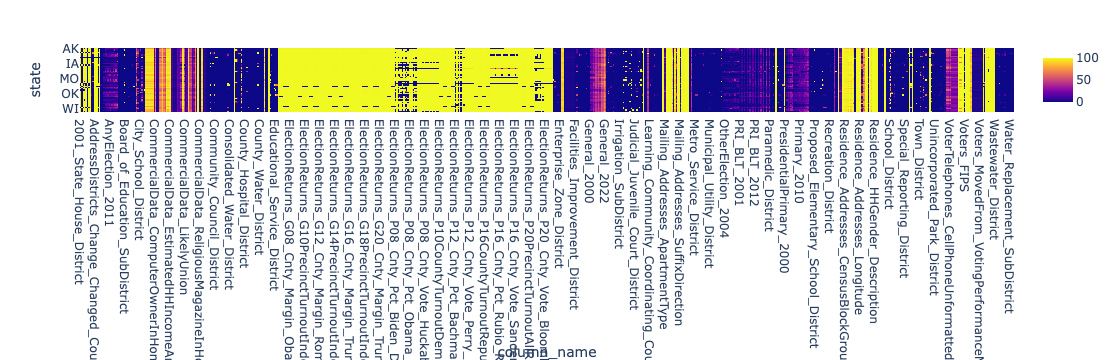

In [16]:
# Visualizations for voter file sparsity by state

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load your CSV file into a DataFrame
df = pd.read_csv('~/Downloads/proportionNullByColAndState.csv')

# Pivot the DataFrame
matrix = df.pivot(index='state', columns='column_name', values='non_null_percentage')

# plotly interactive heatmap
fig = px.imshow(matrix, aspect='auto')

fig.show()


### Identifying info columns only (no Yes/null election turnout columns)

In [17]:
identifying_columns_only = {'2001_State_House_District': 1,
 '2001_State_Legislative_District': 1,
 '2001_State_Senate_District': 1,
 '2001_US_Congressional_District': 1,
 '2010_State_House_District': 1,
 '2010_State_Legislative_District': 1,
 '2010_State_Senate_District': 1,
 '2010_US_Congressional_District': 1,
 '4H_Livestock_District': 1,
 'AbsenteeTypes_Description': 1,
 'AddressDistricts_Change_Changed_CD': 1,
 'AddressDistricts_Change_Changed_County': 1,
 'AddressDistricts_Change_Changed_HD': 1,
 'AddressDistricts_Change_Changed_LD': 1,
 'AddressDistricts_Change_Changed_SD': 1,
 'Airport_District': 1,
 'Annexation_District': 1,
 'Aquatic_Center_District': 1,
 'Aquatic_District': 1,
 'Assessment_District': 1,
 'Bay_Area_Rapid_Transit': 1,
 'Board_of_Education_District': 1,
 'Board_of_Education_SubDistrict': 1,
 'Bonds_District': 1,
 'Borough': 1,
 'Borough_Ward': 1,
 'Career_Center': 1,
 'Cemetery_District': 1,
 'Central_Committee_District': 1,
 'Chemical_Control_District': 1,
 'City': 1,
 'City_Council_Commissioner_District': 1,
 'City_Mayoral_District': 1,
 'City_School_District': 1,
 'City_Ward': 1,
 'Coast_Water_District': 1,
 'College_Board_District': 1,
 'CommercialData_AreaMedianEducationYears': 1,
 'CommercialData_AreaMedianHousingValue': 1,
 'CommercialData_AreaPcntHHMarriedCoupleNoChild': 1,
 'CommercialData_AreaPcntHHMarriedCoupleWithChild': 1,
 'CommercialData_AreaPcntHHSpanishSpeaking': 1,
 'CommercialData_AreaPcntHHWithChildren': 1,
 'CommercialData_BookBuyerInHome': 1,
 'CommercialData_ComputerOwnerInHome': 1,
 'CommercialData_CulinaryInterestMagazineInHome': 1,
 'CommercialData_DoItYourselferMagazineInHome': 1,
 'CommercialData_DonatesEnvironmentCauseInHome': 1,
 'CommercialData_DonatesToCharityInHome': 1,
 'CommercialData_DwellingType': 1,
 'CommercialData_DwellingUnitSize': 1,
 'CommercialData_Education': 1,
 'CommercialData_EstHomeValue': 1,
 'CommercialData_EstimatedAreaMedianHHIncome': 1,
 'CommercialData_EstimatedHHIncome': 1,
 'CommercialData_EstimatedHHIncomeAmount': 1,
 'CommercialData_FamilyMagazineInHome': 1,
 'CommercialData_FemaleOrientedMagazineInHome': 1,
 'CommercialData_FinancialMagazineInHome': 1,
 'CommercialData_GardeningMagazineInHome': 1,
 'CommercialData_HHComposition': 1,
 'CommercialData_HealthFitnessMagazineInHome': 1,
 'CommercialData_HomePurchaseDate': 1,
 'CommercialData_HomePurchasePrice': 1,
 'CommercialData_ISPSA': 1,
 'CommercialData_LandValue': 1,
 'CommercialData_LikelyUnion': 1,
 'CommercialData_MosaicZ4': 1,
 'CommercialData_MosaicZ4Global': 1,
 'CommercialData_Occupation': 1,
 'CommercialData_OccupationGroup': 1,
 'CommercialData_OccupationIndustry': 1,
 'CommercialData_PoliticalContributerInHome': 1,
 'CommercialData_PresenceOfChildrenCode': 1,
 'CommercialData_PresenceOfPremCredCrdInHome': 1,
 'CommercialData_PropertyType': 1,
 'CommercialData_ReligiousContributorInHome': 1,
 'CommercialData_ReligiousMagazineInHome': 1,
 'CommercialData_StateIncomeDecile': 1,
 'CommercialData_UpscaleBuyerInHome': 1,
 'CommercialData_UpscaleFemaleBuyerInHome': 1,
 'CommercialData_UpscaleMaleBuyerInHome': 1,
 'Committee_Super_District': 1,
 'Communications_District': 1,
 'Community_College': 1,
 'Community_College_At_Large': 1,
 'Community_College_Commissioner_District': 1,
 'Community_College_SubDistrict': 1,
 'Community_Council_District': 1,
 'Community_Council_SubDistrict': 1,
 'Community_Facilities_District': 1,
 'Community_Facilities_SubDistrict': 1,
 'Community_Hospital_District': 1,
 'Community_Planning_Area': 1,
 'Community_Service_District': 1,
 'Community_Service_SubDistrict': 1,
 'Congressional_Township': 1,
 'Conservation_District': 1,
 'Conservation_SubDistrict': 1,
 'Consolidated_Water_District': 1,
 'Control_Zone_District': 1,
 'Corrections_District': 1,
 'County': 1,
 'CountyEthnic_Description': 1,
 'CountyEthnic_LALEthnicCode': 1,
 'County_Board_of_Education_District': 1,
 'County_Board_of_Education_SubDistrict': 1,
 'County_Commissioner_District': 1,
 'County_Community_College_District': 1,
 'County_Fire_District': 1,
 'County_Hospital_District': 1,
 'County_Legislative_District': 1,
 'County_Library_District': 1,
 'County_Memorial_District': 1,
 'County_Paramedic_District': 1,
 'County_Service_Area': 1,
 'County_Service_Area_SubDistrict': 1,
 'County_Sewer_District': 1,
 'County_Superintendent_of_Schools_District': 1,
 'County_Supervisorial_District': 1,
 'County_Unified_School_District': 1,
 'County_Water_District': 1,
 'County_Water_Landowner_District': 1,
 'County_Water_SubDistrict': 1,
 'DateConfidence_Description': 1,
 'Democratic_Convention_Member': 1,
 'Democratic_Zone': 1,
 'Designated_Market_Area_DMA': 1,
 'District_Attorney': 1,
 'Drainage_District': 1,
 'EXT_District': 1,
 'Education_Commission_District': 1,
 'Educational_Service_District': 1,
 'Educational_Service_Subdistrict': 1,
 'Election_Commissioner_District': 1,
 'Elementary_School_District': 1,
 'Elementary_School_SubDistrict': 1,
 'Emergency_Communication_911_District': 1,
 'Emergency_Communication_911_SubDistrict': 1,
 'Enterprise_Zone_District': 1,
 'EthnicGroups_EthnicGroup1Desc': 1,
 'Ethnic_Description': 1,
 'Exempted_Village_School_District': 1,
 'Facilities_Improvement_District': 1,
 'Fire_District': 1,
 'Fire_Maintenance_District': 1,
 'Fire_Protection_District': 1,
 'Fire_Protection_SubDistrict': 1,
 'Fire_Protection_Tax_Measure_District': 1,
 'Fire_Service_Area_District': 1,
 'Fire_SubDistrict': 1,
 'Flood_Control_Zone': 1,
 'Forest_Preserve': 1,
 'Garbage_District': 1,
 'Geological_Hazard_Abatement_District': 1,
 'Hamlet_Community_Area': 1,
 'Health_District': 1,
 'High_School_District': 1,
 'High_School_SubDistrict': 1,
 'Hospital_District': 1,
 'Hospital_SubDistrict': 1,
 'Improvement_Landowner_District': 1,
 'Independent_Fire_District': 1,
 'Irrigation_District': 1,
 'Irrigation_SubDistrict': 1,
 'Island': 1,
 'Judicial_Appellate_District': 1,
 'Judicial_Chancery_Court': 1,
 'Judicial_Circuit_Court_District': 1,
 'Judicial_County_Board_of_Review_District': 1,
 'Judicial_County_Court_District': 1,
 'Judicial_District': 1,
 'Judicial_District_Court_District': 1,
 'Judicial_Family_Court_District': 1,
 'Judicial_Jury_District': 1,
 'Judicial_Juvenile_Court_District': 1,
 'Judicial_Magistrate_Division': 1,
 'Judicial_Sub_Circuit_District': 1,
 'Judicial_Superior_Court_District': 1,
 'Judicial_Supreme_Court_District': 1,
 'Justice_of_the_Peace': 1,
 'LALVOTERID': 1,
 'Land_Commission': 1,
 'Landscaping_And_Lighting_Assessment_Distric': 1,
 'Languages_Description': 1,
 'Law_Enforcement_District': 1,
 'Learning_Community_Coordinating_Council_District': 1,
 'Levee_District': 1,
 'Levee_Reconstruction_Assesment_District': 1,
 'Library_District': 1,
 'Library_Services_District': 1,
 'Library_SubDistrict': 1,
 'Lighting_District': 1,
 'Local_Hospital_District': 1,
 'Local_Park_District': 1,
 'Mailing_Addresses_AddressLine': 1,
 'Mailing_Addresses_ApartmentNum': 1,
 'Mailing_Addresses_ApartmentType': 1,
 'Mailing_Addresses_CassErrStatCode': 1,
 'Mailing_Addresses_CheckDigit': 1,
 'Mailing_Addresses_City': 1,
 'Mailing_Addresses_DPBC': 1,
 'Mailing_Addresses_Designator': 1,
 'Mailing_Addresses_ExtraAddressLine': 1,
 'Mailing_Addresses_HouseNumber': 1,
 'Mailing_Addresses_PrefixDirection': 1,
 'Mailing_Addresses_State': 1,
 'Mailing_Addresses_StreetName': 1,
 'Mailing_Addresses_SuffixDirection': 1,
 'Mailing_Addresses_Zip': 1,
 'Mailing_Addresses_ZipPlus4': 1,
 'Mailing_Families_FamilyID': 1,
 'Mailing_Families_HHCount': 1,
 'Mailing_HHGender_Description': 1,
 'Mailing_HHParties_Description': 1,
 'Maintenance_District': 1,
 'MaritalStatus_Description': 1,
 'Master_Plan_District': 1,
 'Memorial_District': 1,
 'Metro_Service_District': 1,
 'Metro_Service_Subdistrict': 1,
 'Metro_Transit_District': 1,
 'Metropolitan_Water_District': 1,
 'Middle_School_District': 1,
 'MilitaryStatus_Description': 1,
 'Mosquito_Abatement_District': 1,
 'Mountain_Water_District': 1,
 'Multi_township_Assessor': 1,
 'Municipal_Advisory_Council_District': 1,
 'Municipal_Court_District': 1,
 'Municipal_Utility_District': 1,
 'Municipal_Utility_SubDistrict': 1,
 'Municipal_Water_District': 1,
 'Municipal_Water_SubDistrict': 1,
 'Museum_District': 1,
 'Northeast_Soil_and_Water_District': 1,
 'Open_Space_District': 1,
 'Open_Space_SubDistrict': 1,
 'Other': 1,
 'Paramedic_District': 1,
 'Park_Commissioner_District': 1,
 'Park_District': 1,
 'Park_SubDistrict': 1,
 'Parties_Description': 1,
 'Planning_Area_District': 1,
 'Police_District': 1,
 'Port_District': 1,
 'Port_SubDistrict': 1,
 'Power_District': 1,
 'Precinct': 1,
 'Proposed_City': 1,
 'Proposed_City_Commissioner_District': 1,
 'Proposed_Community_College': 1,
 'Proposed_District': 1,
 'Proposed_Elementary_School_District': 1,
 'Proposed_Fire_District': 1,
 'Proposed_Unified_School_District': 1,
 'Public_Airport_District': 1,
 'Public_Regulation_Commission': 1,
 'Public_Service_Commission_District': 1,
 'Public_Utility_District': 1,
 'Public_Utility_SubDistrict': 1,
 'Rapid_Transit_District': 1,
 'Rapid_Transit_SubDistrict': 1,
 'Reclamation_District': 1,
 'Recreation_District': 1,
 'Recreational_SubDistrict': 1,
 'Regional_Office_of_Education_District': 1,
 'Religions_Description': 1,
 'Republican_Area': 1,
 'Republican_Convention_Member': 1,
 'Residence_Addresses_AddressLine': 1,
 'Residence_Addresses_ApartmentNum': 1,
 'Residence_Addresses_ApartmentType': 1,
 'Residence_Addresses_CassErrStatCode': 1,
 'Residence_Addresses_CensusBlock': 1,
 'Residence_Addresses_CensusBlockGroup': 1,
 'Residence_Addresses_CensusTract': 1,
 'Residence_Addresses_CheckDigit': 1,
 'Residence_Addresses_City': 1,
 'Residence_Addresses_DPBC': 1,
 'Residence_Addresses_Density': 1,
 'Residence_Addresses_Designator': 1,
 'Residence_Addresses_ExtraAddressLine': 1,
 'Residence_Addresses_HouseNumber': 1,
 'Residence_Addresses_LatLongAccuracy': 1,
 'Residence_Addresses_Latitude': 1,
 'Residence_Addresses_Longitude': 1,
 'Residence_Addresses_PrefixDirection': 1,
 'Residence_Addresses_Property_HomeSq_Footage': 1,
 'Residence_Addresses_Property_LandSq_Footage': 1,
 'Residence_Addresses_State': 1,
 'Residence_Addresses_StreetName': 1,
 'Residence_Addresses_SuffixDirection': 1,
 'Residence_Addresses_Zip': 1,
 'Residence_Addresses_ZipPlus4': 1,
 'Residence_Families_FamilyID': 1,
 'Residence_Families_HHCount': 1,
 'Residence_HHGender_Description': 1,
 'Residence_HHParties_Description': 1,
 'Resort_Improvement_District': 1,
 'Resource_Conservation_District': 1,
 'River_Water_District': 1,
 'Road_Maintenance_District': 1,
 'Rural_Service_District': 1,
 'SEQUENCE': 1,
 'Sanitary_District': 1,
 'Sanitary_SubDistrict': 1,
 'School_Board_District': 1,
 'School_District': 1,
 'School_District_Vocational': 1,
 'School_Facilities_Improvement_District': 1,
 'School_Subdistrict': 1,
 'Service_Area_District': 1,
 'Sewer_District': 1,
 'Sewer_Maintenance_District': 1,
 'Sewer_SubDistrict': 1,
 'Snow_Removal_District': 1,
 'Soil_And_Water_District': 1,
 'Soil_And_Water_District_At_Large': 1,
 'Special_Reporting_District': 1,
 'Special_Tax_District': 1,
 'State_Board_of_Equalization': 1,
 'State_House_District': 1,
 'State_Legislative_District': 1,
 'State_Senate_District': 1,
 'Storm_Water_District': 1,
 'Street_Lighting_District': 1,
 'Superintendent_of_Schools_District': 1,
 'TV_Translator_District': 1,
 'Town_Council': 1,
 'Town_District': 1,
 'Town_Ward': 1,
 'Township': 1,
 'Township_Ward': 1,
 'Transit_District': 1,
 'Transit_SubDistrict': 1,
 'TriCity_Service_District': 1,
 'US_Congressional_District': 1,
 'Unified_School_District': 1,
 'Unified_School_SubDistrict': 1,
 'Unincorporated_District': 1,
 'Unincorporated_Park_District': 1,
 'Unprotected_Fire_District': 1,
 'Ute_Creek_Soil_District': 1,
 'Vector_Control_District': 1,
 'Village': 1,
 'Village_Ward': 1,
 'Vote_By_Mail_Area': 1,
 'VoterParties_Change_Changed_Party': 1,
 'VoterTelephones_CellConfidenceCode': 1,
 'VoterTelephones_CellPhoneFormatted': 1,
 'VoterTelephones_CellPhoneOnly': 1,
 'VoterTelephones_CellPhoneUnformatted': 1,
 'VoterTelephones_Landline7Digit': 1,
 'VoterTelephones_LandlineAreaCode': 1,
 'VoterTelephones_LandlineConfidenceCode': 1,
 'VoterTelephones_LandlineFormatted': 1,
 'VoterTelephones_LandlineUnformatted': 1,
 'Voters_Active': 1,
 'Voters_Age': 1,
 'Voters_BirthDate': 1,
 'Voters_CalculatedRegDate': 1,
 'Voters_CountyVoterID': 1,
 'Voters_FIPS': 1,
 'Voters_FirstName': 1,
 'Voters_Gender': 1,
 'Voters_LastName': 1,
 'Voters_MiddleName': 1,
 'Voters_MovedFrom_Date': 1,
 'Voters_MovedFrom_Party_Description': 1,
 'Voters_MovedFrom_State': 1,
 'Voters_MovedFrom_VotingPerformanceEvenYearGeneral': 1,
 'Voters_MovedFrom_VotingPerformanceEvenYearGeneralAndPrimary': 1,
 'Voters_MovedFrom_VotingPerformanceEvenYearPrimary': 1,
 'Voters_MovedFrom_VotingPerformanceMinorElection': 1,
 'Voters_NameSuffix': 1,
 'Voters_OfficialRegDate': 1,
 'Voters_PlaceOfBirth': 1,
 'Voters_SequenceOddEven': 1,
 'Voters_SequenceZigZag': 1,
 'Voters_StateVoterID': 1,
 'Wastewater_District': 1,
 'Water_Agency': 1,
 'Water_Agency_SubDistrict': 1,
 'Water_Conservation_District': 1,
 'Water_Conservation_SubDistrict': 1,
 'Water_Control__Water_Conservation': 1,
 'Water_Control__Water_Conservation_SubDistrict': 1,
 'Water_District': 1,
 'Water_Public_Utility_District': 1,
 'Water_Public_Utility_Subdistrict': 1,
 'Water_Replacement_District': 1,
 'Water_Replacement_SubDistrict': 1,
 'Water_SubDistrict': 1,
 'Weed_District': 1}

# Filter the Dataframe
df_id_only = df[df.column_name.isin(identifying_columns_only)] 
# Pivot the DataFrame
matrix_id_info_only = df_id_only.pivot(index='state', columns='column_name', values='non_null_percentage')
# plotly interactive heatmap
fig = px.imshow(matrix_id_info_only, aspect='auto')

fig.show()